第二次互评作业 程云来 3120230948

代码仓库地址：https://github.com/Tony6656/Association-rules
如果要运行直接打开work.ipynb即可。

1. SNAP数据集的处理（文献发表时间数据集分析）

1.1数据预处理

    数据集表示物理热力学论文1983-2001年内论文的发表编号。首先，将论文对应到同一个引用列表中,引用列表的含义是归纳出引用当前论文的发表时间。

In [1]:
import pandas as pd

#citations = pd.read_csv('cit-HepPh.txt/Cit-HepPh.txt',delimiter='\t')
pub = pd.read_csv('cit-HepPh-dates.txt/cit-HepPh-dates.txt',delimiter='\t')

for i in range(0,len(pub['time'])):
    x = pub['time'][i].split('-')
    pub['time'][i] = x[0]
grouped  = pub.groupby('id')['time'].apply(list)
print(grouped)


C:\Users\13192\AppData\Local\Temp\ipykernel_25696\3524007319.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pub['time'][i] = x[0]


id
1001         [2000]
1002         [2000]
1003         [2000]
1004         [2000]
1005         [2000]
              ...  
119912458    [1999]
119912463    [1999]
119912473    [1999]
119912491    [1999]
119912558    [1999]
Name: time, Length: 37621, dtype: object


1.2频繁模式的挖掘

    利用mlxtend库挖掘当前数据集中的频繁项集，首先将数据预处理得到的引用列表编码，并使用使用apriori算法找出频繁项集。

In [9]:
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules,fpgrowth


transactions = grouped.tolist()
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df = pd.DataFrame(te_ary, columns=te.columns_)


frequent_itemsets = apriori(df, min_support=0.05, use_colnames=True)
print(frequent_itemsets)

result = association_rules(frequent_itemsets, metric="support", min_threshold=0.02)
print(result)

    support itemsets
0  0.052524   (1993)
1  0.076101   (1994)
2  0.089843   (1995)
3  0.102629   (1996)
4  0.111268   (1997)
5  0.122272   (1998)
6  0.130645   (1999)
7  0.134925   (2000)
8  0.137849   (2001)
1
Empty DataFrame
Columns: [antecedents, consequents, antecedent support, consequent support, support, confidence, lift, leverage, conviction, zhangs_metric]
Index: []


1.3频繁项集的可视化

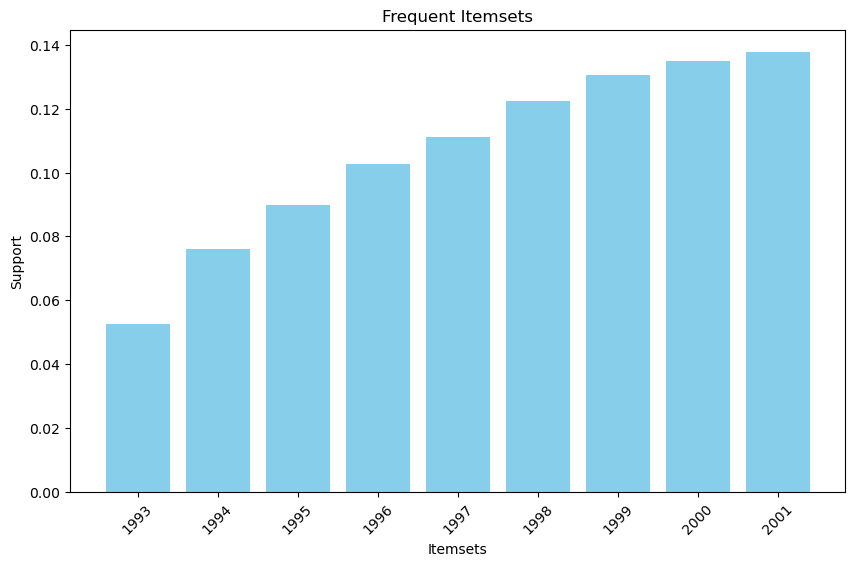

In [4]:
##可视化
# 创建图
import matplotlib.pyplot as plt
# import networkx as nx
# G = nx.Graph()

# 添加节点和边
# for _, row in frequent_itemsets.iterrows():
#     items = list(row['itemsets'])
#     for i in range(len(items)):
#         for j in range(i + 1, len(items)):
#             G.add_edge(items[i], items[j], weight=row['support'])
#
# # 绘制网络图
# plt.figure(figsize=(8, 8))
# pos = nx.spring_layout(G, seed=42)  # positions for all nodes
# edges = G.edges(data=True)
# nx.draw_networkx_nodes(G, pos, node_size=700)
# nx.draw_networkx_edges(G, pos, edgelist=edges, width=6)
# nx.draw_networkx_labels(G, pos, font_size=20, font_family='sans-serif')
# plt.axis('off')
# plt.show()
frequent_itemsets['labels'] = frequent_itemsets['itemsets'].apply(lambda x: ', '.join(list(x)))

# 绘制条形图
plt.figure(figsize=(10, 6))
plt.bar(frequent_itemsets['labels'], frequent_itemsets['support'], color='skyblue')
plt.xlabel('Itemsets')
plt.ylabel('Support')
plt.title('Frequent Itemsets')
plt.xticks(rotation=45)
plt.show()

1.4频繁模式（论文发表时间）分析

    对于当前论文发表年份所作出的条形图可以看出，随着年份的增长，
    该领域内每年文献的发表数量支持度逐年提高，学术活跃度逐年上升。

2 MIND数据集处理

2.1数据预处理

    从网址上下载获取用户的新闻点击历史数据，并对于当前数据进行预处理,将数据转换成为每个用户点击的新闻列表。

In [5]:
import os
import tempfile
import shutil
import urllib
import urllib.request
import zipfile
import pandas as pd

# Temporary folder for data we need during execution of this notebook (we'll clean up
# at the end, we promise)
temp_dir = os.path.join(tempfile.gettempdir(), 'mind')
os.makedirs(temp_dir, exist_ok=True)

# The dataset is split into training and validation set, each with a large and small version.
# The format of the four files are the same.
# For demonstration purpose, we will use small version validation set only.
base_url = 'https://mind201910small.blob.core.windows.net/release'
training_small_url = f'{base_url}/MINDsmall_train.zip'
validation_small_url = f'{base_url}/MINDsmall_dev.zip'
training_large_url = f'{base_url}/MINDlarge_train.zip'
validation_large_url = f'{base_url}/MINDlarge_dev.zip'

def download_url(url,
                 destination_filename=None,
                 progress_updater=None,
                 force_download=False,
                 verbose=True):
    """
    Download a URL to a temporary file
    """
    if not verbose:
        progress_updater = None
    # This is not intended to guarantee uniqueness, we just know it happens to guarantee
    # uniqueness for this application.
    if destination_filename is None:
        url_as_filename = url.replace('://', '_').replace('/', '_')
        destination_filename = \
            os.path.join(temp_dir,url_as_filename)
    if (not force_download) and (os.path.isfile(destination_filename)):
        if verbose:
            print('Bypassing download of already-downloaded file {}'.format(
                os.path.basename(url)))
        return destination_filename
    if verbose:
        print('Downloading file {} to {}'.format(os.path.basename(url),
                                                 destination_filename),
              end='')
    urllib.request.urlretrieve(url, destination_filename, progress_updater)
    assert (os.path.isfile(destination_filename))
    nBytes = os.path.getsize(destination_filename)
    if verbose:
        print('...done, {} bytes.'.format(nBytes))
    return destination_filename

# For demonstration purpose, we will use small version validation set only.
# This file is about 30MB.
zip_path = download_url(validation_small_url,destination_filename = "G:\\北京理工大学学习课程\\学期二\\数据挖掘\\第二次互评作业\\mind\\mind.zip", verbose=True)
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(temp_dir)

os.listdir(temp_dir)

Bypassing download of already-downloaded file MINDsmall_dev.zip


['behaviors.tsv', 'entity_embedding.vec', 'news.tsv', 'relation_embedding.vec']

In [2]:
import pandas as pd

behaviors = pd.read_table('mind/mind/behaviors.tsv',header=None,names=['impression_id', 'user_id', 'time', 'history', 'impressions'])
user_news = behaviors.groupby('user_id')['history'].apply(list).reset_index()
print(user_news)


      user_id                                            history
0          U1  [N23571 N58267 N25682 N10646 N32607 N57737 N52...
1         U10    [N27612 N36699 N64777 N9120 N9803 N57967 N2945]
2      U10000  [N10059 N46978 N53234 N3345 N3345 N9155 N9653 ...
3      U10002  [N27448 N10059 N28467 N64777 N18881 N33117 N12...
4      U10004  [N38118 N55805 N43482 N15402 N15627 N18870 N52...
...       ...                                                ...
49995   U9990                                            [N6616]
49996   U9994                                           [N52551]
49997   U9996  [N28296 N4719 N60340 N31165 N8448, N28296 N471...
49998   U9998  [N53832 N46483 N32643 N60209 N49146 N16233 N19...
49999   U9999  [N64503 N20039 N447 N10865 N59026 N12972 N2557...

[50000 rows x 2 columns]


2.2频繁项集分析和关联规则挖掘

    利用apriori算法挖掘出预处理数据集中的频繁项集意见对应的关联规则挖掘。

In [5]:
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import fpgrowth,association_rules,apriori
# from apyori import apriori
res = []
transactions = user_news['history'].tolist()
for trans in transactions:
    x = []
    for i in range(0,len(trans)):
        trans[i] = str(trans[i])
        x.extend(trans[i].split(' '))
    res.append(x)
print(res[0])
# 使用TransactionEncoder
te = TransactionEncoder()
te_ary = te.fit(res).transform(res)
df = pd.DataFrame(te_ary, columns=te.columns_)
req = apriori(df, min_support=0.01, use_colnames=True)
print(req)
# print(next(frequent_itemsets))
# for id,i in enumerate(frequent_itemsets):
#     print(i)

# def getSubset(fromList, totalList):
#     """
#     生成集合的所有子集
#     :param fromList:
#     :param totalList:
#     """
#     for i in range(len(fromList)):
#         t = [fromList[i]]
#         tt = frozenset(set(fromList) - set(t))  # k-1项子集
#
#         if tt not in totalList:
#             totalList.append(tt)
#             tt = list(tt)
#             if len(tt) > 1:
#                 getSubset(tt, totalList)  # 所有非1项子集
# def cal(freqSet, H, supportData, ruleList, minConf):
#     """
#     计算置信度，并剔除小于最小置信度的数据,这里利用了提升度概念
#     :param freqSet: k项频繁集
#     :param H: k项频繁集对应的所有子集
#     :param supportData: 支持度
#     :param RuleList: 强关联规则
#     :param minConf: 最小置信度
#     """
#     # 遍历freqSet中的所有子集并计算置信度
#     for conseq in H:
#         conf = supportData[freqSet] / supportData[freqSet - conseq]  # 相当于把事务总数抵消了
#
#         # 提升度lift计算lift=p(a&b)/p(a)*p(b)
#         lift = supportData[freqSet] / (supportData[conseq] * supportData[freqSet - conseq])
#         if conf >= minConf and lift > 1:
#             print(freqSet - conseq, '-->', conseq, '支持度', round(supportData[freqSet], 6), '置信度：', round(conf, 6),
#                   'lift值为：', round(lift, 6))
#             ruleList.append((freqSet - conseq, conseq, conf))
#
#
# bigRuleList = []
# for i in range(1,len(frequent_itemsets)):
#     print(frequent_itemsets[i].items)
#     for i in frequent_itemsets[i]:
#         print(i)
#         h1 = list(i.items)
#         all_subset = []
#         getSubset(h1,all_subset)
#         cal(i.items, all_subset, i.support, bigRuleList, 0.1)
#
# print(bigRuleList)
# print(get_rule(frequent_itemsets,minConf=0.01))
rules = association_rules(req, metric="confidence", min_threshold=0.2)
print(rules)

['N23571', 'N58267', 'N25682', 'N10646', 'N32607', 'N57737', 'N52301', 'N596', 'N24356', 'N13374', 'N40207', 'N62058']
     support          itemsets
0    0.03390          (N10059)
1    0.01194          (N10078)
2    0.01516          (N10235)
3    0.01022          (N10347)
4    0.01130          (N10359)
..       ...               ...
504  0.01026  (N51706, N55189)
505  0.01038  (N51706, N59704)
506  0.01346    (N51706, N871)
507  0.01290    (N55189, N871)
508  0.01098    (N59704, N871)

[509 rows x 2 columns]
   antecedents consequents  antecedent support  consequent support  support  \
0      (N1150)    (N29177)             0.04866             0.07092  0.01458   
1     (N29177)     (N1150)             0.07092             0.04866  0.01458   
2      (N1150)      (N306)             0.04866             0.11318  0.01126   
3     (N13138)      (N306)             0.04324             0.11318  0.01034   
4     (N13138)    (N42620)             0.04324             0.11256  0.01030   
5     (N162

2.3频繁模式挖掘的可视化

    利用网络图去进行关联规则分析的可视化，网络图越密集的节点，说明该新闻的热度更高，被浏览量和点击率也可能会更高。

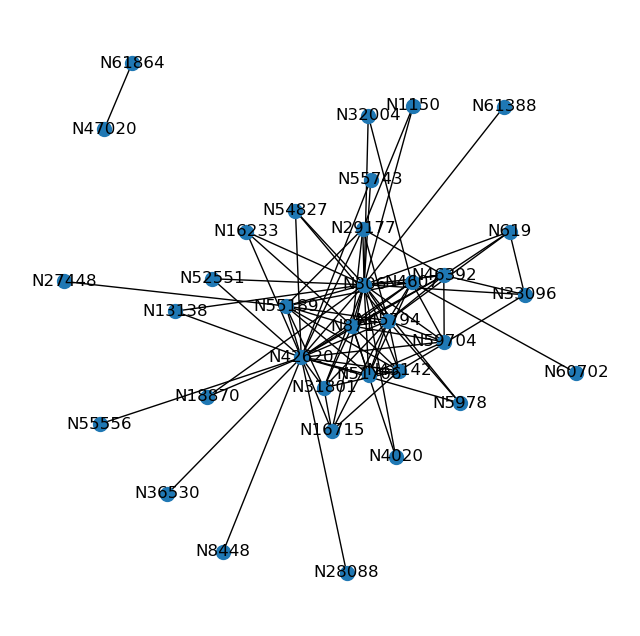

In [9]:
import networkx as nx
import matplotlib.pyplot as plt
frequent_itemsets = req
# 创建图
G = nx.Graph()

# 添加节点和边
for _, row in frequent_itemsets.iterrows():
    items = list(row['itemsets'])
    for i in range(len(items)):
        for j in range(i + 1, len(items)):
            G.add_edge(items[i], items[j], weight=row['support'])

# 绘制网络图
plt.figure(figsize=(8, 8))
pos = nx.spring_layout(G, seed=42)  # positions for all nodes
edges = G.edges(data=True)
nx.draw_networkx_nodes(G, pos, node_size=100)
nx.draw_networkx_edges(G, pos, edgelist=edges, width=1)
nx.draw_networkx_labels(G, pos, font_size=12, font_family='sans-serif')
plt.axis('off')
plt.show()



2.4频繁模式（新闻热度）分析

    根据可视化后的网络图可以知道，编号为N42520，N306等的新闻与其他新闻联系联系较多。
    这说明该类新闻在数据采样的时间内，被用户点击量较大，新闻热度较高。
